# Homework #8 (Due 11/06/2019, 11:59pm)
## Variational Inference for Bayesian Neural Networks

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2019**

**Name: Ian Weaver**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import scipy as sp_base
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import sys
%matplotlib inline
weqwdwqdwqwqdwqdqwwqqwadasdasdsaadadwadafasdsafasfadasfasfasfaasdasdsjhabasdvgsa

In [2]:
# Plot configs
fig_wide = (11, 4)
%config InlineBackend.figure_format = "retina"
%matplotlib inline
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

## Problem Description: Bayesian Neural Network Regression
In Homework #7, you explored sampling from the posteriors of ***Bayesian neural networks*** using HMC. In Lab #8 you'll explore the extent to which HMC can be inefficient or ineffective for sampling from certain types of posteriors. In this homework, you will study variational approximations of BNN posteriors, especially when compared to the posteriors obtained by sampling (in Homework #7). The data is the same as the one for Homework #7.

### Part I: Implement Black-Box Variational Inference with the Reparametrization Trick

1. (**BBVI with the Reparametrization Trick**) Implement BBVI with the reparametrization trick for approximating an arbitrary posterior $p(w| \text{Data})$ by an isotropic Gaussian $\mathcal{N}(\mu, \Sigma)$, where $\Sigma$ is a diagonal matrix. See Lecture #15 or the example code from [autograd's github repo](https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py). 
<br><br>

2. (**Unit Test**) Check that your implementation is correct by approximating the posterior of the following Bayesian logistic regression model:
\begin{align}
w &\sim \mathcal{N}(0, 1)\\
Y^{(n)} &\sim Ber(\text{sigm}(wX^{(n)} + 10))
\end{align}
  where $w$, $Y^{(n)}$, $X^{(n)}$ are a real scalar valued random variables, and where the data consists of a single observation $(Y=1, X=-20)$.

  The true posterior $p(w | Y=1, X=-20)$ should look like the following (i.e. the true posterior is left-skewed):
<img src="./logistic_posterior.png" style='height:200px;'>
  Your mean-field variational approximation should be a Gaussian with mean -0.321 and standard deviation 0.876 (all approximate).
<br><br>

#### 1.1 BBVI with the Reparametrization Trick

In [3]:
def black_box_variational_inference(logprob, D, num_samples):
    
    """
    Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557
    code taken from:
    https://github.com/HIPS/autograd/blob/master/examples/black_box_svi.py
    """

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = np.random.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params


def variational_inference(Sigma_W, y, x, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    sigmoid = lambda x: 1. / (1. + np.exp(-x))
    
    #define the log prior on the model parameters
    # multivariate normal
    def log_prior(W):
        constant_W = -0.5 * (D * np.log(2 * np.pi) + np.log(Sigma_W_det))
        exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
        log_p_W = constant_W + exponential_W
        return log_p_W

    #define the log likelihood
    # bernouilli
    def log_lklhd(W):
        bern_arg = sigmoid(W*1 + 10.)
        return np.log(bern_arg)

    #define the log joint density
    log_density = lambda w, t: log_lklhd(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = \
    black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print(
                    "Iteration {} lower bound {}; gradient mag: {}".format(
                    t, 
                    -objective(params, t), 
                    np.linalg.norm(gradient(params, t))
                    )
                )

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = np.ones(D)
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])
    
    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)
    
    return variational_params 

#### 1.2 Unit Test

In [19]:
## load data
x = np.array([-20.])
y = np.array([1.])
D = 1

# VI params
Sigma_W = np.array([[1]])
S = 400
max_iteration = 2_000
step_size = 1e-1
verbose=True

vi_params = variational_inference(Sigma_W, x, y, S, max_iteration, step_size, verbose)

Optimizing variational parameters...
Iteration 0 lower bound -100.00001670156132; gradient mag: 1.414201752733763
Iteration 100 lower bound -89.50004981737577; gradient mag: 1.0000043196938413
Iteration 200 lower bound -79.50004559789356; gradient mag: 1.000000000025754
Iteration 300 lower bound -69.50004569786732; gradient mag: 1.0000000000000022
Iteration 400 lower bound -59.50004579786711; gradient mag: 1.0
Iteration 500 lower bound -49.50004589786733; gradient mag: 1.0
Iteration 600 lower bound -39.50004599786755; gradient mag: 1.0
Iteration 700 lower bound -29.5000460978677; gradient mag: 1.0
Iteration 800 lower bound -19.500046197867565; gradient mag: 1.0
Iteration 900 lower bound -9.500046299394446; gradient mag: 0.9999999978847491
Iteration 1000 lower bound -0.022685003127555392; gradient mag: 0.27358365434731496
Iteration 1100 lower bound 0.009311992239024125; gradient mag: 0.027719792589524245
Iteration 1200 lower bound 0.03386541529436227; gradient mag: 0.054183652310202765


[0.0161316] [[1.00615344]]


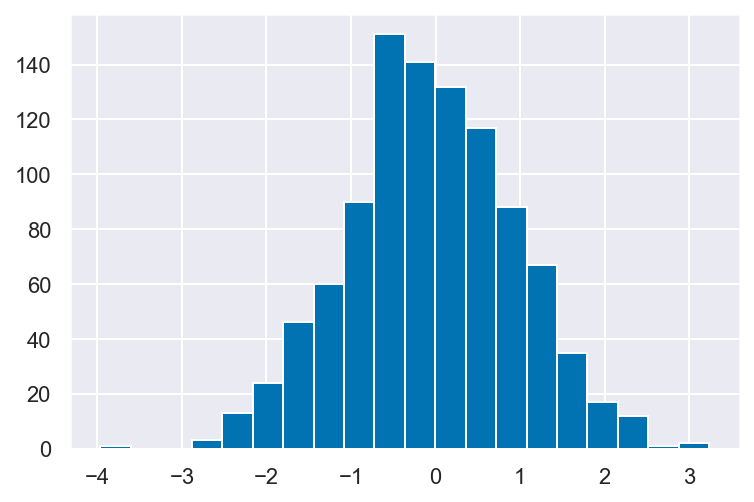

In [35]:
vi_params[:D]
var_means = vi_params[:D]
var_variance = np.diag(np.exp(vi_params[D:])**2)
print(var_means, np.sqrt(var_variance))
x = np.random.normal(loc=var_means, scale=np.sqrt(var_variance), size=1_000)
plt.hist(x, bins=20)
plt.show()

### Part II: Approximate the Posterior of a Bayesian Neural Network

1. (**Variational Inference for BNNs**) We will implement the following Bayesian model for the data:
\begin{align}
\mathbf{W} &\sim \mathcal{N}(0, 5^2 \mathbf{I}_{D\times D})\\
\mu^{(n)} &= g_{\mathbf{W}}(\mathbf{X}^{(n)})\\
Y^{(n)} &\sim \mathcal{N}(\mu^{(n)}, 0.5^2)
\end{align}
  where $g_{\mathbf{W}}$ is a neural network with parameters $\mathbf{W}$ represented as a vector in $\mathbb{R}^{D}$ with $D$ being the total number of parameters (including biases). Just as in HW #7, use a network with a single hidden layer, 5 hidden nodes and rbf activation function.

  Implement the log of the joint distribution in `autograd`'s version of `numpy`, i.e. implement $\log \left[p(\mathbf{W})\prod_{n=1}^N p(Y^{(n)} |\mathbf{X}^{(n)} , \mathbf{W}) \right]$.
  
  ***Hint:*** you'll need to write out the log of the various Gaussian pdf's and implement their formulae using `autograd`'s numpy functions.<br><br>

4. (**Approximate the Posterior**) Use BBVI with the reparametrization trick to approximate the posterior of the Bayesian neural network with a mean-field Gaussian variational family (i.e. an isotropic Gaussian). Please set learning rate and maximum iteration choices as you see fit!<br><br>
  
4. (**Visualize the Posterior Predictive**) Visualize 100 samples $\mathbf{W}^s$ from your approximate posterior of $\mathbf{W}$ by ploting the neural network outputs with weight $\mathbf{W}^s$ plus a random noise $\epsilon \sim \mathcal{N}(0, 0.5^2)$ at 100 equally spaced x-values between -8 and 8:
``` python 
x_test = np.linspace(-8, 8, 100)
y_test = nn.forward(sample, x_test.reshape((1, -1)))
```
  where `sample` is a sample from the approximate posterior of $\mathbf{W}$.<br><br>

5. (**Computing the Fit**) Compute the posterior predictive log likelihood of the observed data under your model. 
<br><br>
  
6. (**Model Evaluation**) Compare the posterior predictive visualization and the posterior predictive log likelihood obtained from BBVI with the reparametrization trick to the ones you obtained in HW #7. Can you say whether or not your posterior approximation is good? How does approximating the posterior effect our estimation of epistemic and aleatoric uncertainty?<br><br>

7. (**Extra Credit**) Get your HMC sampler to converge for this BNN model and this dataset.

